# Applies Deep Learning to ePodium dataset for prediction of Dyslexia.

#### Import Packages

In [18]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from functions import epodium_deep_learning, display_helper
from models.dnn import fully_connected_model
from models.transformer import TransformerModel

import local_paths

#### Choose which processed data to use

In [2]:
processing_method_widget = ipywidgets.RadioButtons(options=['autoreject', 'ransac'], 
                                                   value='autoreject', 
                                                   description='processing:')
display(processing_method_widget)

RadioButtons(description='processing:', options=('autoreject', 'ransac'), value='autoreject')

<br>

## Preparing data as input to the deep learning models.

#### Check number of clean epochs* in each file after processing and split into train and test dataset

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

In [3]:
if(processing_method_widget.value == "autoreject"):
    path_processed = local_paths.ePod_processed_autoreject
if(processing_method_widget.value == "ransac"):
    path_processed = local_paths.ePod_processed_ransac

train, test = epodium_deep_learning.split_train_test_datasets(path_processed)

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


#### Create Iterator Sequence as input to feed the model
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence


In [5]:
train_sequence = epodium_deep_learning.EvokedDataIterator(train)
test_sequence = epodium_deep_learning.EvokedDataIterator(test)

x, y = train_sequence.__getitem__(0)
x.shape

(96, 32, 512)

<br>

## Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.

__dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ (Sex, At risk of dyslexia, first standard, standard, deviant)


#### Choose Deep Learning model

In [6]:
model_widget = ipywidgets.RadioButtons(options=['fully_connected', 'transformer'],
                                       value='transformer', 
                                       description='processing:')
display(model_widget)

RadioButtons(description='processing:', index=1, options=('fully_connected', 'transformer'), value='transforme…

#### Train model

In [9]:
if(model_widget.value == "fully_connected"): # TODO
    model = fully_connected_model()
    
if(model_widget.value == "transformer"):
    model = TransformerModel()

# Save file with names of test set, so 
path_testset = os.path.join(local_paths.models, model_widget.value + "_testset.txt")

with open(path_testset, 'w') as f:
    for participant in test:
        f.write(participant + '\n')


    
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=[Precision(), BinaryAccuracy(), Recall()])

model_path = os.path.join(local_paths.models, model_widget.value + ".hdf5")
checkpointer = ModelCheckpoint(filepath = model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1)

history = model.fit(x=train_sequence,
                    validation_data=test_sequence,
                    epochs=20,

                    callbacks=[checkpointer, reduce_lr])

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 1.4607 - precision_2: 0.4178 - binary_accuracy: 0.5273 - recall_2: 0.4936WARNING:tensorflow:Model was constructed with shape (None, 16384) for input KerasTensor(type_spec=TensorSpec(shape=(None, 16384), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'"), but it was called on an input with incompatible shape (None, None, None).

Epoch 1: val_loss improved from inf to 0.79428, saving model to /volume-ceph/floris_storage/models/transformer.hdf5
18/18 [==============================] - 258s 14s/step - loss: 1.4607 - precision_2: 0.4178 - binary_accuracy: 0.5273 - recall_2: 0.4936 - val_loss: 0.7943 - val_precision_2: 0.4375 - val_binary_accuracy: 0.6000 - val_recall_2: 0.2333 - lr: 1.0000e-04
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 1.2929 - precision_2: 0.4257 - binary_accuracy: 0.5382 - recall_2: 0.4775 
Epoch 2: val_loss improved from 0.79428 to 0.7048

In [13]:
path_history = os.path.join(local_paths.models, model_widget.value + "_history.npy")
np.save(path_history, history.history)


#### Show Results

In [16]:
model_extension = '.hdf5'

path_models = glob.glob(os.path.join(local_paths.models, '*' + model_extension))

models = []
paths_model_file = []
paths_model_history = []

for path_model in path_models:
    model_temp = os.path.splitext(path_model)[0]    
    models.append(os.path.basename(model_temp))
    paths_model_file.append(model_temp + model_extension)
    paths_model_history.append(model_temp + '_history.npy')

model = ipywidgets.Select(options=models, description='Models:')
display(model)

Select(description='Models:', options=('transformer', 'fully_connected'), value='transformer')

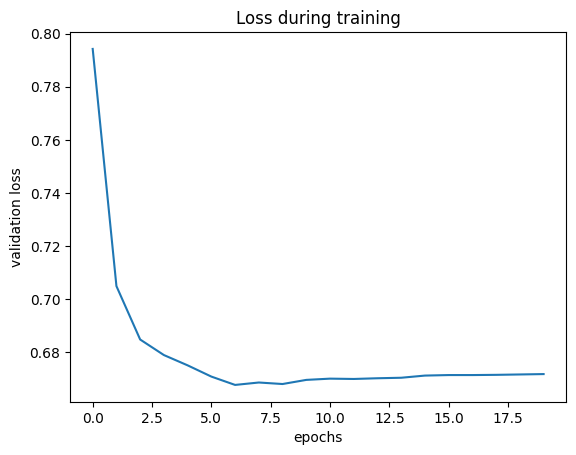

In [25]:
history = np.load(paths_model_history[model.index], allow_pickle=True).item()
plt.plot(history['loss'])
display_helper.show_plot(x = range(len(history['loss'])), y = history['val_loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Loss during training")


#### Make predictions on test set

In [ ]:

## test set:
# with open(the_filename, 'r') as f:
#     my_list = [line.rstrip('\n') for line in f]